**Import the Required Libraries**

In [ ]:
# !pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
from pmdarima.arima import auto_arima

# Visualization
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error,mean_squared_log_error

#Statistics
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from pmdarima import auto_arima

**Read the Dowloaded Dataset**

In [ ]:
# Import data
df = pd.read_excel('/content/Weather Data.xlsx')
df.head()

,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,2022-01-01,27.6,14.1,20.7,28.3,14.1,20.8,16.3,77.7,0.0,...,18.3,8,NaN,2022-01-01T07:07:39,2022-01-01T18:09:39,0.95,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"43063099999,43111099999,remote,43060099999"
1,2022-01-02,27.1,15.7,20.9,27.6,15.7,21.0,16.6,78.5,0.0,...,17.8,7,NaN,2022-01-02T07:07:59,2022-01-02T18:10:16,0.98,Clear,Clear conditions throughout the day.,clear-day,"43063099999,43111099999,remote,43060099999"
2,2022-01-03,28.5,15.7,20.9,28.6,15.7,21.0,16.1,76.3,0.0,...,17.8,7,NaN,2022-01-03T07:08:18,2022-01-03T18:10:52,0.00,Partially cloudy,Becoming cloudy in the afternoon.,partly-cloudy-day,"43063099999,43111099999,remote,43060099999"
3,2022-01-04,27.2,15.5,20.7,27.5,15.5,20.8,15.0,72.2,0.0,...,18.3,8,NaN,2022-01-04T07:08:36,2022-01-04T18:11:29,0.05,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"43063099999,43111099999,remote,43060099999"
4,2022-01-05,29.9,13.8,20.1,29.3,13.8,20.1,14.3,72.0,0.0,...,17.9,7,NaN,2022-01-05T07:08:52,2022-01-05T18:12:07,0.08,Clear,Clear conditions throughout the day.,clear-day,"43063099999,43111099999,remote,43060099999"


**Filter only required Columns** 

In [ ]:
data = df[['datetime','temp','feelslike']]
data.head()

,datetime,temp,feelslike
0,2022-01-01,20.7,20.8
1,2022-01-02,20.9,21.0
2,2022-01-03,20.9,21.0
3,2022-01-04,20.7,20.8
4,2022-01-05,20.1,20.1


In [ ]:
# data
feels_like_temp = data.set_index('datetime')
feels_like_temp.head()

,temp,feelslike
datetime,,
2022-01-01,20.7,20.8
2022-01-02,20.9,21.0
2022-01-03,20.9,21.0
2022-01-04,20.7,20.8
2022-01-05,20.1,20.1


In [ ]:
# Visualizaing the data
print("Blueline: Feels Like Temp, Red Line: Actual Temp")
fig = px.line(data_frame=data, x = data['datetime'], y=data['feelslike'])
fig.add_scatter(x = data['datetime'], y=data['temp'])
fig.show()

Blueline: Feels Like Temp, Red Line: Actual Temp


In [ ]:
#Considering only Feels_like_temp for further analysis
feels_like_temp = feels_like_temp['feelslike']
feels_like_temp.head()

datetime
2022-01-01    20.8
2022-01-02    21.0
2022-01-03    21.0
2022-01-04    20.8
2022-01-05    20.1
Name: feelslike, dtype: float64

**Check for Statitonarity in the Dataset using Dickey Fuller Test**

In [ ]:
#Performing Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller 
def test_stationarity(timeseries):
    
    #Determining rolling statistics
    rolmean = timeseries.rolling(4).mean() # around 4 weeks on each month
    rolstd = timeseries.rolling(4).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    if dfoutput['p-value'] < 0.05:
        print('result : time series is stationary')
    else : print('result : time series is not stationary')

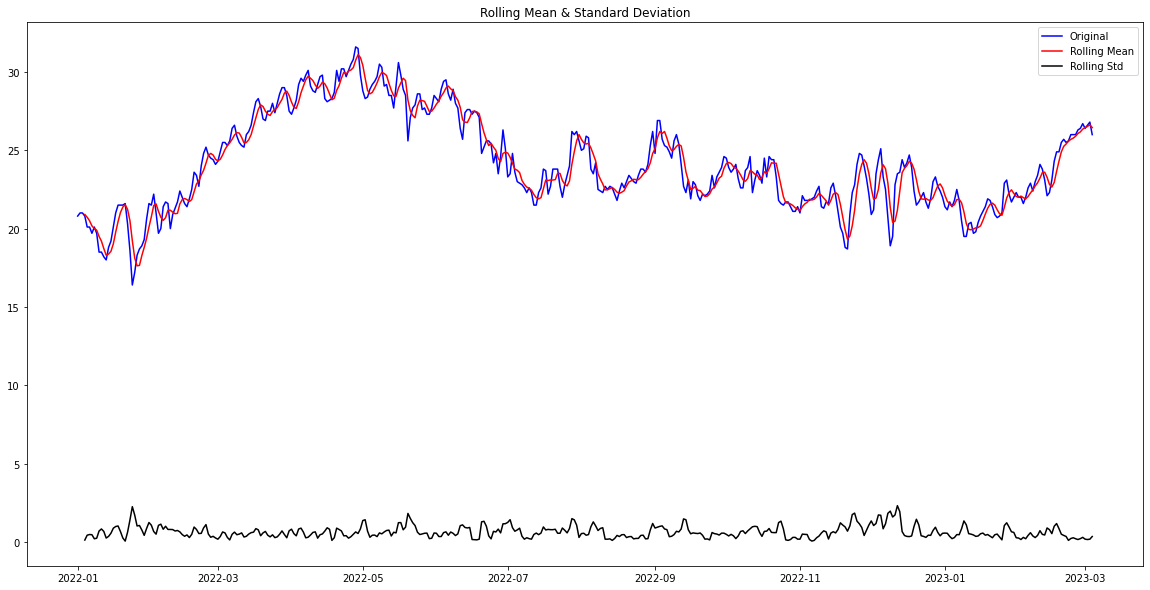

Results of Dickey-Fuller Test:
Test Statistic                  -1.867105
p-value                          0.347691
#Lags Used                       7.000000
Number of Observations Used    420.000000
Critical Value (1%)             -3.446016
Critical Value (5%)             -2.868446
Critical Value (10%)            -2.570449
dtype: float64
result : time series is not stationary


In [ ]:
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 20,10
test_stationarity(feels_like_temp['feelslike'])

**It is Necessary for the data to be stationary to run ARIMA, Hence the data is to be transformed**

**Data Transformation (Non Stationary to Stationary)** 


1. Use NumPy’s square root function to transform the required column
2. Then shift the transformation by one using the “shift’ function.
3. Take the difference between both the original transformation and shift.


In [ ]:
#As the data is not stationary it is now required to convert it into stationary
df_log=np.sqrt(feels_like_temp['feelslike'])
df_diff=df_log.diff().dropna()

**Now that time series data is Transformed, we should check if it is stationary now**

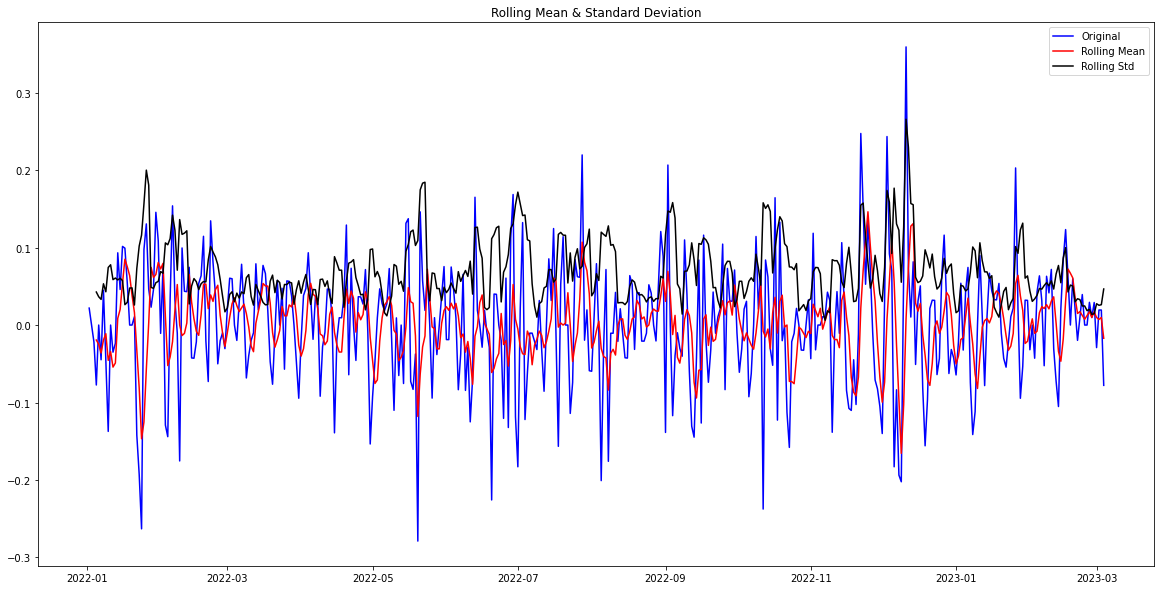

Results of Dickey-Fuller Test:
Test Statistic                -1.075728e+01
p-value                        2.573776e-19
#Lags Used                     6.000000e+00
Number of Observations Used    4.200000e+02
Critical Value (1%)           -3.446016e+00
Critical Value (5%)           -2.868446e+00
Critical Value (10%)          -2.570449e+00
dtype: float64
result : time series is stationary


In [ ]:
test_stationarity(df_diff)

**Note: The data is stationary now After Transformation**

**Another way of dealing with Non stationary Data in ARIMA Models using Integrate(I) concept**


In Auto ARIMA(p,d,q)(P,D,Q), the model itself will generate the optimal p, d, and q values which would be suitable for the data set to provide better forecasting even for Non stationary Data.
1. p — the number of autoregressive
2. d — degree of differencing
3. q — the number of moving average terms
4. (P, D, Q )— represents the (p,d,q) for the seasonal part of the time series
5. m — refers to the number of periods in each season

Note: In the Auto ARIMA model, note that small p,d,q values represent non-seasonal components, and capital P, D, Q represent seasonal components


.



**Auto Arima Model takes in only log transformed time series Values**

In [ ]:
#Log Transformation of Time Series
df_log = np.log(feels_like_temp['feelslike'])

#Splitting of Data into Train & Test (at 90:10 ratio)

train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data.index, y=train_data,
                    mode='lines',
                    name='Train data'))
fig.add_trace(go.Scatter(x=test_data.index, y=test_data,
                    mode='lines',
                    name='Test Data'))

**Finding Out optimal ARIMA(p,d,q)(P,D,Q)m parameters between (0-3)**

In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1482.195, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1491.694, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1495.582, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1484.190, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1495.334, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1497.457, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1515.126, Time=0.76 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1515.583, Time=0.86 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1517.582, Time=1.90 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1500.046, Time=0.46 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1515.286, Time=1.87 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-1500.836, Time=0.27 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1480.972, Time=1.37 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1519.566, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0

**Optimal Values Found out during Analysis are: p: 2, q: 1, d: 1, P: 0,Q: 0, D:0, M:0**

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  382
Model:               SARIMAX(2, 1, 1)   Log Likelihood                 763.783
Date:                Sun, 19 Feb 2023   AIC                          -1519.566
Time:                        10:45:19   BIC                          -1503.795
Sample:                    01-04-2022   HQIC                         -1513.309
                         - 01-20-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9656      0.064     14.983      0.000       0.839       1.092
ar.L2         -0.2986      0.041     -7.362      0.000      -0.378      -0.219
ma.L1         -0.8278      0.065    -12.736      0.0

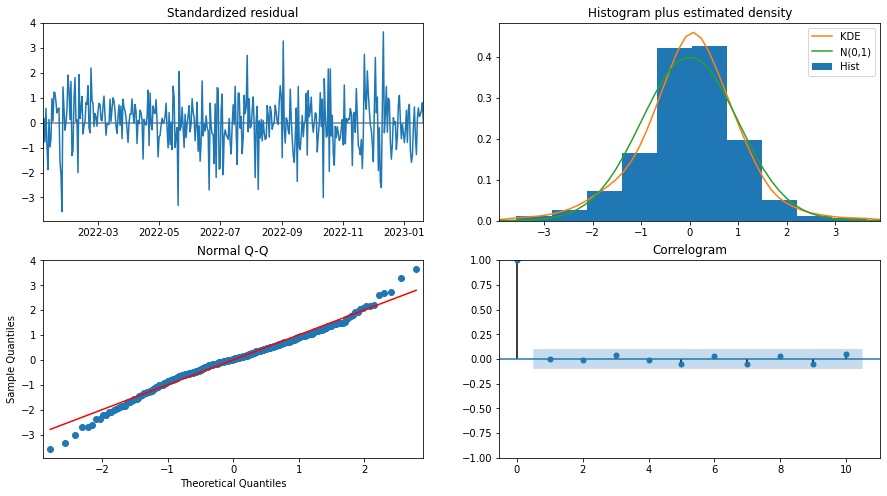

In [ ]:
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

**Implementing the final ARIMA Model with hypertuned Parameters**

In [ ]:
#Modeling
# Build Model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(2,1,1))  
fitted = model.fit()  
print(fitted.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                               SARIMAX Results                                
Dep. Variable:              feelslike   No. Observations:                  382
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 763.783
Date:                Sun, 19 Feb 2023   AIC                          -1519.566
Time:                        10:48:13   BIC                          -1503.795
Sample:                    01-04-2022   HQIC                         -1513.309
                         - 01-20-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9656      0.064     14.983      0.000       0.839       1.092
ar.L2         -0.2986      0.041     -7.362      0.000      -0.378      -0.219
ma.L1         -0.8278      0.065    -12.736      0.0

**Predicting the Feels Like Temperature in Hinjewadi Pune, using the fitted model**

In [ ]:
forecast= fitted.get_forecast(len(test_data))
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.05)

In [ ]:
fc = forecast.predicted_mean

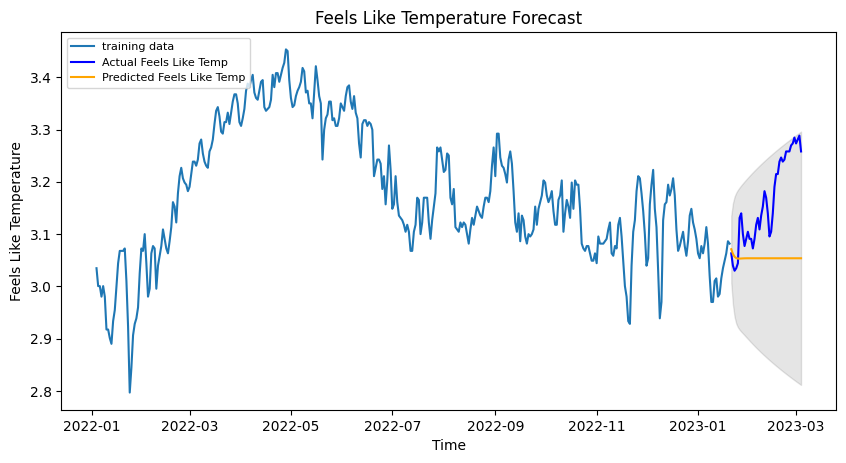

In [ ]:
fc.index = test_data.index
yhat_conf_int.index = test_data.index
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(yhat_conf_int.iloc[:, 0], index=test_data.index)
upper_series = pd.Series(yhat_conf_int.iloc[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Feels Like Temp')
plt.plot(fc_series, color = 'orange',label='Predicted Feels Like Temp')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Feels Like Temperature Forecast')
plt.xlabel('Time')
plt.ylabel('Feels Like Temperature')
plt.legend(loc='upper left', fontsize=8)
plt.show()

**Results of ARIMA Model**

In [ ]:
# report performance
import math
from sklearn.metrics import mean_absolute_percentage_error as mape
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = mape(fc,test_data)
print('MAPE: '+str(mape))

MSE: 0.0182633193172032
MAE: 0.11148755220351023
RMSE: 0.13514184887444453
MAPE: 0.0365053264474063


**Applying LSTM Models**

In [ ]:
# Convert the dataframe to a numpy array
dataset = feels_like_temp.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

407

In [ ]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# scaled_data

In [ ]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.28947368, 0.30263158, 0.30263158, 0.28947368, 0.24342105,
       0.24342105, 0.21710526, 0.24342105, 0.21710526, 0.13815789,
       0.13815789, 0.11842105, 0.10526316, 0.15789474, 0.18421053,
       0.24342105, 0.30263158, 0.33552632, 0.33552632, 0.33552632,
       0.34210526, 0.25657895, 0.14473684, 0.        , 0.05263158,
       0.125     , 0.15131579, 0.16447368, 0.19078947, 0.27631579,
       0.34210526, 0.33552632, 0.38157895, 0.30263158, 0.21710526,
       0.23684211, 0.32894737, 0.34868421, 0.34210526, 0.23684211,
       0.29605263, 0.32236842, 0.34868421, 0.39473684, 0.36842105,
       0.34210526, 0.32894737, 0.36184211, 0.40131579, 0.47368421,
       0.46052632, 0.41447368, 0.5       , 0.55263158, 0.57894737,
       0.54605263, 0.53289474, 0.52631579, 0.50657895, 0.51973684])]
[0.5592105263157894]

[array([0.28947368, 0.30263158, 0.30263158, 0.28947368, 0.24342105,
       0.24342105, 0.21710526, 0.24342105, 0.21710526, 0.13815789,
       0.13815789, 0.11842105, 0.105

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=30)


Epoch 1/30
347/347 [==============================] - 17s 38ms/step - loss: 0.0120
Epoch 2/30
347/347 [==============================] - 13s 39ms/step - loss: 0.0073
Epoch 3/30
347/347 [==============================] - 13s 39ms/step - loss: 0.0058
Epoch 4/30
347/347 [==============================] - 13s 39ms/step - loss: 0.0041
Epoch 5/30
347/347 [==============================] - 13s 39ms/step - loss: 0.0038
Epoch 6/30
347/347 [==============================] - 13s 39ms/step - loss: 0.0041
Epoch 7/30
347/347 [==============================] - 14s 39ms/step - loss: 0.0041
Epoch 8/30
347/347 [==============================] - 13s 38ms/step - loss: 0.0036
Epoch 9/30
347/347 [==============================] - 13s 38ms/step - loss: 0.0036
Epoch 10/30
347/347 [==============================] - 13s 38ms/step - loss: 0.0034
Epoch 11/30
347/347 [==============================] - 13s 38ms/step - loss: 0.0034
Epoch 12/30
347/347 [==============================] - 13s 39ms/step - loss: 0.0033
E

**Performance of LSTM Model in predicting Feels Like Temperature of Hinjewadi Pune**

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print("RMSE of LSTM: ",rmse)

# Get the Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test, predictions)
print("MAE of LSTM: ",MAE)

# Get the Mean Absolute Percentage Error (MAE)
MAPE = mean_absolute_percentage_error(y_test, predictions)
print("MAPE of LSTM: ",MAPE)


1/1 [==============================] - 1s 889ms/step
RMSE of LSTM:  0.5323708055713023
MAE of LSTM:  0.4565203530447824
MAPE of LSTM:  0.018423917016675347


**Results:**

*   **Model / RMSE / MAE / MAPE**
*    ARIMA / 0.14 / 0.11 / 0.04
*    LSTM / 0.53 / 0.46 /  0.02

Note: MAPE means Mean Absolute Percentage Error it explains the average difference, lower the value of MAPE, better is the prediction of the model

**Conclusion:** Lesser MAPE Value for LSTM Indicates that LSTM has an accuracy of 98% in forecasting the feels like temperature of Hinjewadi i.e, better than the performance of ARIMA Model with a MAPE Value of 0.04 i.e., 96% Accurate